In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from PIL import Image
from scipy import ndimage
import pandas as pd
import imageio
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers

from datetime import datetime
from packaging import version

%matplotlib inline

Using TensorFlow backend.


In [3]:
# labels = np.genfromtxt('labels.csv', delimiter=',')
labels = pd.read_csv('labels.csv', float_precision='road_trip')
labels.head(5)

,Unnamed: 0,img_name,base,base color R,base color G,base color B,specular,specular color R,specular color G,specular color B,specular roughness,metalness
0,0,0.bmp,0.196696,[0.02551167982996516,0.523569,0.09533690194549593],0.903675,[0.9414576345001383,0.927580,0.418087362819755],0.120439,0.941755
1,1,1.bmp,0.563387,[0.13560656102894886,0.715835,0.6311335628961977],0.381407,[0.9228773407900674,0.328530,0.294482323738513],0.439152,0.511734
2,2,2.bmp,0.433630,[0.06292513279208145,0.468129,0.49781547380782],0.622876,[0.8260393377700712,0.115993,0.1549741111822439],0.646591,0.490058
3,3,3.bmp,0.471443,[0.8909351516333082,0.133360,0.7187711144029106],0.419356,[0.08579008506320773,0.466882,0.36951439970192435],0.154928,0.632136
4,4,4.bmp,0.172493,[0.1089380911674539,0.179026,0.4079338804909298],0.893968,[0.9620524644071147,0.906355,0.3523653506316685],0.708425,0.002353


In [4]:
labels["base color R"] = labels["base color R"].str[1:]
labels["base color B"] = labels["base color B"].str[:-1]
labels["specular color R"] = labels["specular color R"].str[1:]
labels["specular color B"] = labels["specular color B"].str[:-1]
labels["img_name"] = labels["img_name"].str[:-3]+"jpg"

In [5]:
labels.head(5)

,Unnamed: 0,img_name,base,base color R,base color G,base color B,specular,specular color R,specular color G,specular color B,specular roughness,metalness
0,0,0.jpg,0.196696,0.02551167982996516,0.523569,0.09533690194549593,0.903675,0.9414576345001383,0.927580,0.418087362819755,0.120439,0.941755
1,1,1.jpg,0.563387,0.13560656102894886,0.715835,0.6311335628961977,0.381407,0.9228773407900674,0.328530,0.294482323738513,0.439152,0.511734
2,2,2.jpg,0.433630,0.06292513279208145,0.468129,0.49781547380782,0.622876,0.8260393377700712,0.115993,0.1549741111822439,0.646591,0.490058
3,3,3.jpg,0.471443,0.8909351516333082,0.133360,0.7187711144029106,0.419356,0.08579008506320773,0.466882,0.36951439970192435,0.154928,0.632136
4,4,4.jpg,0.172493,0.1089380911674539,0.179026,0.4079338804909298,0.893968,0.9620524644071147,0.906355,0.3523653506316685,0.708425,0.002353


In [6]:
vector_values = labels.iloc[:,2:]
vector_values = vector_values.astype(float)
vector_values.head(5)

,base,base color R,base color G,base color B,specular,specular color R,specular color G,specular color B,specular roughness,metalness
0,0.196696,0.025512,0.523569,0.095337,0.903675,0.941458,0.927580,0.418087,0.120439,0.941755
1,0.563387,0.135607,0.715835,0.631134,0.381407,0.922877,0.328530,0.294482,0.439152,0.511734
2,0.433630,0.062925,0.468129,0.497815,0.622876,0.826039,0.115993,0.154974,0.646591,0.490058
3,0.471443,0.890935,0.133360,0.718771,0.419356,0.085790,0.466882,0.369514,0.154928,0.632136
4,0.172493,0.108938,0.179026,0.407934,0.893968,0.962052,0.906355,0.352365,0.708425,0.002353


In [7]:
# rest of 6000 images
labels_rest = pd.read_csv('big_dataset.csv', float_precision='road_trip')
labels_rest["img_name"] = labels_rest["img_name"].str[:-3]+"jpg"
labels_rest.head(5)

,Unnamed: 0,img_name,base,base color R,base color G,base color B,specular,specular color R,specular color G,specular color B,specular roughness,metalness
0,4000,4000.jpg,0.956147,0.486100,0.262378,0.702265,0.056947,0.088813,0.853888,0.124773,0.405244,0.964655
1,4001,4001.jpg,0.587651,0.695236,0.433226,0.486428,0.651687,0.227340,0.425121,0.056233,0.527052,0.572431
2,4002,4002.jpg,0.675467,0.998616,0.459375,0.994240,0.499777,0.345599,0.251364,0.710467,0.658970,0.453777
3,4003,4003.jpg,0.158920,0.282565,0.337818,0.930465,0.046933,0.887962,0.067276,0.742097,0.258651,0.273307
4,4004,4004.jpg,0.909876,0.661214,0.575602,0.091078,0.096691,0.628311,0.097340,0.273665,0.885754,0.661140


In [8]:
vector_values2 = labels_rest.iloc[:,2:]
vector_values2 = vector_values2.astype(float)

In [9]:
# concat the 4000 and 6000 images for full dataset
frames = [vector_values, vector_values2]
vector_value = pd.concat(frames)
np_labels = vector_value.values

THE BELOW CELL TAKES AGES TO RUN. ONLY RUN IT ONCE.

(855, 1280, 3)

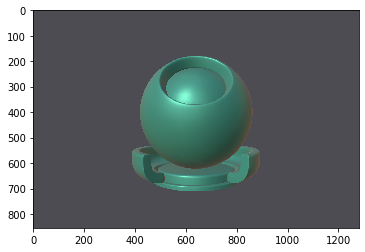

In [10]:
fname = "./data/images/1.jpg"
arr = np.array(imageio.imread(fname))
plt.imshow(arr)
arr.shape

In [11]:
BATCH_SIZE = 25
IMG_HEIGHT = 855
IMG_WIDTH = 1280

DATASET_SIZE = 10000
TRAIN_SIZE = 6500
VAL_SIZE = 1500
TEST_SIZE = int(DATASET_SIZE * .2)

In [12]:
def crop(img):
    # Note: image_data_format is 'channel_last'
    x = 212
    y = 0
    crop_size = 855
    return tf.image.crop_to_bounding_box(img, 0, 212, crop_size, crop_size)

def label_gen(labels, batch_size):
    num = 0
    while True:
        if (num >= len(labels)):
            num = 0
        if (num == 0 and num + batch_size >= len(labels)):
            yield labels;
        else:
            yield labels[num: num + batch_size, :]
        num += batch_size

    
def crop_generator(batches, labels, crop_length, batch_size, steps):
    i = 0
    while True:
        batch_x = batches[i]
        labels_x = next(labels)
        start_y = (855 - crop_length) // 2
        start_x = (1280 - crop_length) // 2
        batch_crops = np.zeros((batch_size, 224, 224, 3))
        for i in range(batch_crops.shape[0]):
            batch_crops[i] = crop(batch_x[0][i])
        assert(labels_x.shape[0] == batch_crops.shape[0], "labels size = " + str(labels_x.shape[0]))
        yield (batch_crops, labels_x)

        i = i + 1
        if (i >= steps):
            i = 0

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

<>:30: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:30: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:30: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-12-9021de915d88>:30: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(labels_x.shape[0] == batch_crops.shape[0], "labels size = " + str(labels_x.shape[0]))


In [13]:
# 90 percent split
train_data_gen = image_generator.flow_from_directory(directory=str("./data_split_large/train_data"),
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle = False,
                                                     classes = None)
val_data_gen = image_generator.flow_from_directory(directory=str("./data_split_large/val_data"),
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle = False,
                                                     classes = None)
test_data_gen = image_generator.flow_from_directory(directory=str("./data_split_large/test_data"),
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size=BATCH_SIZE,
                                                     classes = None)

Found 6500 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.


In [14]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

In [15]:
# Creating label generators for each dataset (65/15/20 percent split)
Y_train = np_labels[:TRAIN_SIZE]
Y_val = np_labels[TRAIN_SIZE:TRAIN_SIZE + VAL_SIZE]
Y_test = np_labels[TRAIN_SIZE + VAL_SIZE:]
Y_train_gen = label_gen(Y_train, BATCH_SIZE)
Y_val_gen = label_gen(Y_val, BATCH_SIZE)
Y_test_gen = label_gen(Y_test, BATCH_SIZE)

In [16]:
model = tf.keras.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(10,input_shape=(None, 855 * 855 * 3), activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [17]:
train_crops = crop_generator(train_data_gen, Y_train_gen, 855, BATCH_SIZE, int(6500/BATCH_SIZE))
val_crops = crop_generator(val_data_gen, Y_val_gen, 855, BATCH_SIZE, int(1500/BATCH_SIZE))
test_crops = crop_generator(test_data_gen, Y_test_gen, 855, BATCH_SIZE, int(2000/BATCH_SIZE))

In [1]:
image_batch, label_batch = next(train_crops)
show_batch(image_batch, label_batch)

NameError: name 'train_crops' is not defined

In [16]:
# Define the Keras TensorBoard callback.
logdir="logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
STEP_SIZE_TRAIN=int(6500/BATCH_SIZE)
STEP_SIZE_VALID=int(1500/BATCH_SIZE)

# fit generator
model.fit_generator(generator=train_crops,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_crops,
                    validation_steps= STEP_SIZE_VALID,
                    epochs=10,
                    verbose=True,
                    use_multiprocessing = False,
                    max_queue_size=10, 
                    workers=1,
                    callbacks=[]
)

Epoch 1/10


In [ ]:
parameters = model(train_data_gen, Y_train, test_data_gen, Y_test)